# Подготовка модели распознавания рукописных букв и цифр

In [1]:
!pip install torch torchvision
!pip install emnist

In [289]:
import os
import pickle
import PIL
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize, InterpolationMode
from torchvision import datasets
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torchvision.datasets import EMNIST

## 1. Подготовка данных

In [2]:
transform = Compose([
    # Resize((1, 28*28)),
    ToTensor(),
    Normalize([0.5], [0.5]),
])

train_dataset = EMNIST('data/', 'balanced', train=True, download=True, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, transform=transform)

print('Train:', len(train_dataset))
print('Valid:', len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)

print('(min, max):', (train_dataset[0][0].min(), train_dataset[0][0].max()))

print('Image shape', train_dataset[1][0].numpy().shape)

Train: 112800
Valid: 18800
(min, max): (tensor(-1.), tensor(1.))
Image shape (1, 28, 28)


In [3]:
classes = train_dataset.classes
n_classes = len(classes)
n_classes

47

In [4]:
img, lbl = train_dataset[0]
print(lbl, img.size)
display(img)

45 <built-in method size of Tensor object at 0x7f26fe945f70>


tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -0.9922, -0.9451, -0.7490, -0.7176, -0.8353, -0.9765, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -0.9373, -0.7412, -0.1137, -0.0275, -0

## 2. Построение модели

### Подготовка

In [178]:
def train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre, stop_score=None):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')

        if epoch % val_fre == 0:
            score = validate(model, val_loader, loss_f)
            if not (score is None):
                if score >= stop_score:
                    break

def validate(model, val_loader, loss_f):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}')
    model.train()
    return acc

### Модель 1

In [6]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features, n_classes):
        super(MLP, self).__init__()
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features, hid_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_features, n_classes)

    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [22]:
model_mlp = MLP(in_features=28*28, hid_features=1024, n_classes=n_classes)
print(model_mlp)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mlp.parameters(), lr=1e-1)

n_epoch = 20
val_fre = 10

MLP(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=47, bias=True)
)


In [23]:
train(model_mlp, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
validate(model_mlp, val_loader, loss_f)

Epoch: 0
Iter: 0 	Loss: 3.867163896560669
Iter: 10 	Loss: 3.494060754776001
Iter: 20 	Loss: 3.074035406112671
Iter: 30 	Loss: 2.6450343132019043
Iter: 40 	Loss: 2.3304078578948975
Iter: 50 	Loss: 2.014904260635376
Iter: 60 	Loss: 1.8162835836410522
Iter: 70 	Loss: 1.7267307043075562
Iter: 80 	Loss: 1.6570755243301392
Iter: 90 	Loss: 1.557195782661438
Iter: 100 	Loss: 1.5408804416656494
Iter: 110 	Loss: 1.5594550371170044
Mean Train Loss: 2.229496

Val Loss: 1.497547 	Accuracy: 0.590531914893617
Epoch: 1
Iter: 0 	Loss: 1.413588047027588
Iter: 10 	Loss: 1.469893217086792
Iter: 20 	Loss: 1.4606088399887085
Iter: 30 	Loss: 1.36228609085083
Iter: 40 	Loss: 1.356097936630249
Iter: 50 	Loss: 1.3363268375396729
Iter: 60 	Loss: 1.4339755773544312
Iter: 70 	Loss: 1.3009954690933228
Iter: 80 	Loss: 1.3081750869750977
Iter: 90 	Loss: 1.3987444639205933
Iter: 100 	Loss: 1.341029167175293
Iter: 110 	Loss: 1.2340338230133057
Mean Train Loss: 1.365774

Epoch: 2
Iter: 0 	Loss: 1.3537696599960327
Iter: 

### Модель 2

In [25]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features, n_classes):
        super(MLP, self).__init__()
        
        self.c2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding='same')
        self.relu = torch.nn.ReLU()

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(in_features, hid_features)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(hid_features, n_classes)

    def forward(self, x):

        x = self.c2d(x)
        x = self.relu(x)

        x = self.flat(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x

In [26]:
model_mlp = MLP(in_features=28*28, hid_features=1024, n_classes=n_classes)
print(model_mlp)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mlp.parameters(), lr=1e-1)

n_epoch = 20
val_fre = 10

MLP(
  (c2d): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=47, bias=True)
)


In [20]:
train(model_mlp, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
validate(model_mlp, val_loader, loss_f)

Epoch: 0
Iter: 0 	Loss: 3.8581442832946777
Iter: 10 	Loss: 3.724702835083008
Iter: 20 	Loss: 3.4315223693847656
Iter: 30 	Loss: 2.7515220642089844
Iter: 40 	Loss: 2.1507158279418945
Iter: 50 	Loss: 2.0570120811462402
Iter: 60 	Loss: 1.8007221221923828
Iter: 70 	Loss: 1.656969428062439
Iter: 80 	Loss: 1.6705248355865479
Iter: 90 	Loss: 1.4827837944030762
Iter: 100 	Loss: 1.4646893739700317
Iter: 110 	Loss: 1.3434853553771973
Mean Train Loss: 2.203719

Val Loss: 1.306466 	Accuracy: 0.6388297872340426
Epoch: 1
Iter: 0 	Loss: 1.2571821212768555
Iter: 10 	Loss: 1.256620168685913
Iter: 20 	Loss: 1.204832911491394
Iter: 30 	Loss: 1.1461554765701294
Iter: 40 	Loss: 1.1659326553344727
Iter: 50 	Loss: 1.1643372774124146
Iter: 60 	Loss: 1.1841437816619873
Iter: 70 	Loss: 1.0684943199157715
Iter: 80 	Loss: 0.984028160572052
Iter: 90 	Loss: 1.0479137897491455
Iter: 100 	Loss: 0.9675272107124329
Iter: 110 	Loss: 0.9970071911811829
Mean Train Loss: 1.126725

Epoch: 2
Iter: 0 	Loss: 0.9646202921867371

### Модель 3

In [28]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features, n_classes):
        super(MLP, self).__init__()
        
        self.c2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding='same')
        self.relu = torch.nn.ReLU()

        self.c2d_2 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding='same')
        self.relu2 = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout()

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(in_features, hid_features)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(hid_features, n_classes)

    def forward(self, x):

        x = self.c2d(x)
        x = self.relu(x)

        x = self.c2d_2(x)
        x = self.relu2(x)

        x = self.dropout(x)

        x = self.flat(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x

In [29]:
model_mlp = MLP(in_features=28*28, hid_features=1024, n_classes=n_classes)
print(model_mlp)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

n_epoch = 40
val_fre = 10

MLP(
  (c2d): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
  (c2d_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=47, bias=True)
)


In [30]:
train(model_mlp, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
validate(model_mlp, val_loader, loss_f)

Epoch: 0
Iter: 0 	Loss: 3.850903272628784
Iter: 10 	Loss: 3.8534061908721924
Iter: 20 	Loss: 3.850444793701172
Iter: 30 	Loss: 3.8454623222351074
Iter: 40 	Loss: 3.822042465209961
Iter: 50 	Loss: 3.6900720596313477
Iter: 60 	Loss: 3.2147529125213623
Iter: 70 	Loss: 2.5563395023345947
Iter: 80 	Loss: 2.2325353622436523
Iter: 90 	Loss: 1.9875737428665161
Iter: 100 	Loss: 1.9590357542037964
Iter: 110 	Loss: 1.724751591682434
Mean Train Loss: 3.057067

Val Loss: 1.610988 	Accuracy: 0.5702127659574469
Epoch: 1
Iter: 0 	Loss: 1.6707173585891724
Iter: 10 	Loss: 1.72629976272583
Iter: 20 	Loss: 1.5143519639968872
Iter: 30 	Loss: 1.4349641799926758
Iter: 40 	Loss: 1.4561727046966553
Iter: 50 	Loss: 1.3218684196472168
Iter: 60 	Loss: 1.2246131896972656
Iter: 70 	Loss: 1.2752385139465332
Iter: 80 	Loss: 1.1335668563842773
Iter: 90 	Loss: 1.1322309970855713
Iter: 100 	Loss: 1.068444848060608
Iter: 110 	Loss: 1.0698564052581787
Mean Train Loss: 1.317193

Epoch: 2
Iter: 0 	Loss: 0.9909276366233826
I

### Модель 4

In [86]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features, n_classes):
        super(MLP, self).__init__()
        
        self.c2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding='same')
        self.relu = torch.nn.ReLU()

        self.c2d_2 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding='same')
        self.relu2 = torch.nn.ReLU()

        self.mp2d = torch.nn.MaxPool2d(kernel_size=3, padding=0)

        self.dropout = torch.nn.Dropout()

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(81, hid_features)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(hid_features, n_classes)

    def forward(self, x):

        x = self.c2d(x)
        x = self.relu(x)

        x = self.c2d_2(x)
        x = self.relu2(x)

        x = self.mp2d(x)

        x = self.dropout(x)

        x = self.flat(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x

In [89]:
model_mlp = MLP(in_features=28*28, hid_features=1024, n_classes=n_classes)
print(model_mlp)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

n_epoch = 80
val_fre = 5

MLP(
  (c2d): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
  (c2d_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (mp2d): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=81, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=47, bias=True)
)


In [90]:
train(model_mlp, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
validate(model_mlp, val_loader, loss_f)

Epoch: 0
Iter: 0 	Loss: 3.8529131412506104
Iter: 10 	Loss: 3.8228836059570312
Iter: 20 	Loss: 3.775935173034668
Iter: 30 	Loss: 3.6897621154785156
Iter: 40 	Loss: 3.5021793842315674
Iter: 50 	Loss: 3.206813335418701
Iter: 60 	Loss: 2.9543497562408447
Iter: 70 	Loss: 2.813699722290039
Iter: 80 	Loss: 2.640726089477539
Iter: 90 	Loss: 2.63256573677063
Iter: 100 	Loss: 2.569199323654175
Iter: 110 	Loss: 2.3938071727752686
Mean Train Loss: 3.145835

Val Loss: 1.807159 	Accuracy: 0.5387234042553192
Epoch: 1
Iter: 0 	Loss: 2.488112688064575
Iter: 10 	Loss: 2.4033946990966797
Iter: 20 	Loss: 2.362412929534912
Iter: 30 	Loss: 2.329355239868164
Iter: 40 	Loss: 2.3054630756378174
Iter: 50 	Loss: 2.2855300903320312
Iter: 60 	Loss: 2.275346279144287
Iter: 70 	Loss: 2.1301660537719727
Iter: 80 	Loss: 2.1519827842712402
Iter: 90 	Loss: 2.0696325302124023
Iter: 100 	Loss: 2.1096444129943848
Iter: 110 	Loss: 2.11313796043396
Mean Train Loss: 2.252274

Epoch: 2
Iter: 0 	Loss: 2.108152151107788
Iter: 10

### Модель 5

In [214]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features, n_classes):
        super(MLP, self).__init__()
        
        self.layer1 = nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, padding=0)
        )

        self.layer2 = nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(1024, hid_features)
        self.dropout = torch.nn.Dropout()
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hid_features, n_classes)

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.flat(x)

        # print(x.shape)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x

In [215]:
model_mlp = MLP(in_features=28*28, hid_features=1024, n_classes=n_classes)
print(model_mlp)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

n_epoch = 80
val_fre = 5

MLP(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=47, bias=True)
)


In [216]:
train(model_mlp, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre, stop_score=0.88)
validate(model_mlp, val_loader, loss_f)

Epoch: 0
Iter: 0 	Loss: 3.923083543777466
Iter: 10 	Loss: 1.937178134918213
Iter: 20 	Loss: 1.166095495223999
Iter: 30 	Loss: 0.8840010166168213
Iter: 40 	Loss: 0.8357285261154175
Iter: 50 	Loss: 0.7242832779884338
Iter: 60 	Loss: 0.6619705557823181
Iter: 70 	Loss: 0.695990800857544
Iter: 80 	Loss: 0.5852329134941101
Iter: 90 	Loss: 0.5461660623550415
Iter: 100 	Loss: 0.5850545167922974
Iter: 110 	Loss: 0.5809654593467712
Mean Train Loss: 0.978270

Val Loss: 0.483568 	Accuracy: 0.8423404255319149
Epoch: 1
Iter: 0 	Loss: 0.5077557563781738
Iter: 10 	Loss: 0.540515661239624
Iter: 20 	Loss: 0.5071378946304321
Iter: 30 	Loss: 0.46567171812057495
Iter: 40 	Loss: 0.4588078260421753
Iter: 50 	Loss: 0.4724721610546112
Iter: 60 	Loss: 0.49129700660705566
Iter: 70 	Loss: 0.45680147409439087
Iter: 80 	Loss: 0.44495144486427307
Iter: 90 	Loss: 0.44803866744041443
Iter: 100 	Loss: 0.47411346435546875
Iter: 110 	Loss: 0.44729435443878174
Mean Train Loss: 0.475769

Epoch: 2
Iter: 0 	Loss: 0.368740916

0.8847340425531914

In [225]:
validate(model_mlp, val_loader, loss_f)

Val Loss: 0.325429 	Accuracy: 0.8847340425531914


0.8847340425531914

In [233]:
CHECKPOINT_PATH = os.path.join('myapp', 'model.ckpt')

torch.save({
            'model_state_dict': model_mlp.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'model_kwargs' : {
                    'in_features': 28*28,
                    'hid_features': 1024,
                    'n_classes': n_classes,
                }
            }, CHECKPOINT_PATH)

In [241]:
checkpoint = torch.load(CHECKPOINT_PATH, weights_only=True)

model = MLP(**checkpoint['model_kwargs'])
model.load_state_dict(checkpoint['model_state_dict'])
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

validate(model, val_loader, loss_f)

Val Loss: 0.325429 	Accuracy: 0.8847340425531914


0.8847340425531914

### Тест uvicorn

In [290]:
mapping = pd.read_csv('./emnist-balanced-mapping.txt', sep=' ', names=['label', 'code'])
mapping['char'] = mapping['code'].apply(chr)
mapping.set_index('label', inplace=True)
pd.set_option('display.max_columns', None)
mapping.T

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
code,48,49,50,51,52,53,54,55,56,57,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,97,98,100,101,102,103,104,110,113,114,116
char,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t


In [291]:
def lab2chr(label):
    return mapping.loc[label]['char']

lab2chr(10)

'A'

In [248]:
!pip freeze | grep torch

torch==2.4.1
torchvision==0.19.1


In [249]:
torch.__version__

'2.4.1+cu121'

In [294]:
!uvicorn myapp.main:app

Torch version: 2.4.1+cu121
INFO:     Started server process [261544]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
[W1023 12:49:16.616941322 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
INFO:     127.0.0.1:42258 - "POST /api/predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:42258 - "POST /api/predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:42258 - "POST /api/predict HTTP/1.1" 200 OK
^C
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [261544]


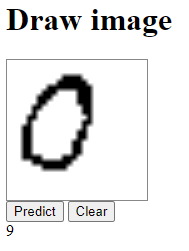 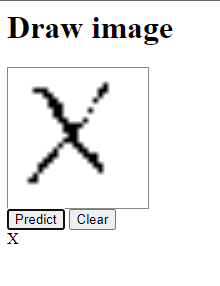 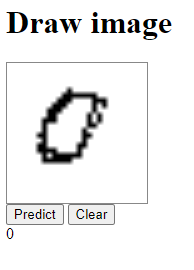 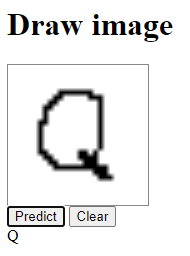 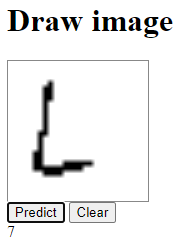
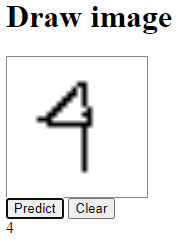

### Docker

`docker build -t numbers_nn .`

![alt text](WindowsTerminal_cx7VkcfVY6.png)

`docker run -p 8000:8000 numbers_nn`

![alt text](WindowsTerminal_y2TIddKExW.png)

![alt text](brave_c3Bj4isfF7.png)